# Song Lyrics Data Visualization Analysis
### <span style="color:red">Sergio Carrazzoni de Toledo Piza</span>

Neste trabalho, foi utilizado o dataset "Music Topics and Metadata", que traz informações sobre músicas lançadas entre 1950 e 2019, como o nome do artista, nome da música, letras e gêneros da música, etc.

O principal objetivo deste trabalho foi tentar encontrar padrões entre o conteúdo das letras e seus respectivos gêneros musicais, utilizando diferentes técnicas de análise textual.

O dataset está disponível em https://data.mendeley.com/datasets/3t9vbwxgr5/1

In [ ]:
# Montando o drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/My Drive/Visualização Computacional/song_lyrics

[Errno 2] No such file or directory: 'drive/My Drive/Visualização Computacional/song_lyrics'
/content


In [ ]:
import pandas as pd
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph
!pip install plotly.express
from plotly import graph_objs as go
import random
random.seed(9361073)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [ ]:
df_original = pd.read_csv('/content/tcc_ceds_music.csv')

In [ ]:
df_original

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,like/girls,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,0.000598,0.000598,0.048857,0.017104,0.263751,0.000598,0.039288,0.000598,0.000598,0.000598,0.000598,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.000000
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,0.001284,0.001284,0.027007,0.001284,0.001284,0.001284,0.118034,0.001284,0.212681,0.051124,0.001284,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.000000
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.158564,0.250668,0.002770,0.323794,0.002770,0.002770,0.002770,0.002770,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.000000
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,0.001548,0.021500,0.001548,0.411536,0.001548,0.001548,0.001548,0.129250,0.001548,0.001548,0.081132,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.000000
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,0.001350,0.001350,0.001350,0.463430,0.001350,0.001350,0.001350,0.001350,0.001350,0.029755,0.001350,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28367,82447,mack 10,10 million ways,2019,hip hop,cause fuck leave scar tick tock clock come kno...,78,0.001350,0.001350,0.001350,0.001350,0.001350,0.001350,0.001350,0.001350,0.391651,0.001350,0.435089,0.001350,0.001350,0.001350,0.065664,0.001350,0.889527,0.759711,0.062549,0.000000,0.751649,0.695686,obscene,0.014286
28368,82448,m.o.p.,ante up (robbin hoodz theory),2019,hip hop,minks things chain ring braclets yap fame come...,67,0.001284,0.001284,0.035338,0.001284,0.001284,0.001284,0.066324,0.203889,0.318910,0.058152,0.134955,0.001284,0.001284,0.040811,0.001284,0.001284,0.662082,0.789580,0.004607,0.000002,0.922712,0.797791,obscene,0.014286
28369,82449,nine,whutcha want?,2019,hip hop,get ban get ban stick crack relax plan attack ...,77,0.001504,0.154302,0.168988,0.001504,0.039755,0.001504,0.035401,0.001504,0.356685,0.001504,0.068684,0.001504,0.001504,0.001504,0.001504,0.001504,0.663165,0.726970,0.104417,0.000001,0.838211,0.767761,obscene,0.014286
28370,82450,will smith,switch,2019,hip hop,check check yeah yeah hear thing call switch g...,67,0.001196,0.001196,0.001196,0.001196,0.048359,0.001196,0.001196,0.001196,0.492434,0.103614,0.001196,0.202659,0.001196,0.070867,0.001196,0.001196,0.883028,0.786888,0.007027,0.000503,0.508450,0.885882,obscene,0.014286


# Carregando e pre-analisando o conjunto de dados

In [ ]:
#df = pd.read_csv('tcc_ceds_music.csv', encoding='utf8')
df = df_original[['lyrics', 'genre']]
df.genre = df.genre.astype('category')
df

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lyrics,genre
0,hold time feel break feel untrue convince spea...,pop
1,believe drop rain fall grow believe darkest ni...,pop
2,sweetheart send letter goodbye secret feel bet...,pop
3,kiss lips want stroll charm mambo chacha merin...,pop
4,till darling till matter know till dream live ...,pop
...,...,...
28367,cause fuck leave scar tick tock clock come kno...,hip hop
28368,minks things chain ring braclets yap fame come...,hip hop
28369,get ban get ban stick crack relax plan attack ...,hip hop
28370,check check yeah yeah hear thing call switch g...,hip hop


In [ ]:
df.genre.unique()

['pop', 'country', 'blues', 'jazz', 'reggae', 'rock', 'hip hop']
Categories (7, object): ['pop', 'country', 'blues', 'jazz', 'reggae', 'rock', 'hip hop']

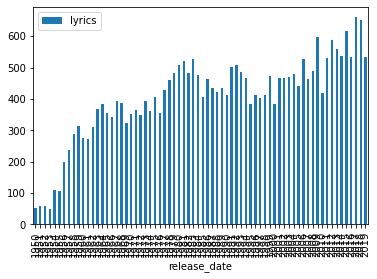

In [ ]:
import matplotlib.pyplot as plt
h = df_original.groupby('release_date').count().reset_index()
#h['gid'] = h.genre.astype('category').cat.codes
h = h[['lyrics', 'release_date']]
#plt.hist(h)
h.plot.bar(x='release_date', y='lyrics')

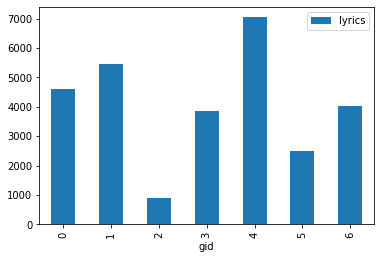

In [ ]:
h = df.groupby('genre').count().reset_index()
h['gid'] = h.genre.astype('category').cat.codes
h = h[['lyrics', 'gid']]
h.plot.bar(x='gid', y='lyrics')

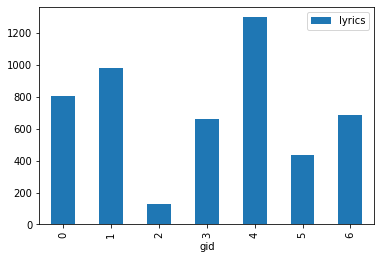

In [ ]:
df_sample = df.sample(n=5000, random_state=1)
h = df_sample.groupby('genre').count().reset_index()
h['gid'] = h.genre.astype('category').cat.codes
h = h[['lyrics', 'gid']]
h.plot.bar(x='gid', y='lyrics')

In [ ]:
df_cluster = df_original.drop(df_original.columns[[0, 1, 2, 3, 5, 6, 29, 30]], 1)
df_cluster = df_cluster.dropna()

df_clustering = df_cluster.drop(df_cluster.columns[0], 1)

kmeans = KMeans(n_clusters=7,n_init=10,init='random',max_iter=300)
kmeans.fit(df_clustering)

df_cluster['cluster'] = kmeans.labels_
df_cluster = df_cluster[['genre', 'cluster']]

In [ ]:
px.parallel_categories(df_cluster)

Ao comparar as métricas das músicas, podemos ver que o estilo não necessariamente condiz com a categoria atribuída a ela durante o processo de clusterização. 

## Computando Bag-of-Words

In [ ]:
# remoção de pontuacao e stopwords

def remove_stopwords(text,lang,domain_stopwords=[]):
  
  stop_words = nltk.corpus.stopwords.words(lang) # lang='portuguese' or lang='english'
  
  s = str(text).lower() # tudo para caixa baixa
  table = str.maketrans({key: None for key in string.punctuation})
  s = s.translate(table) # remove pontuacao
  tokens = word_tokenize(s) #obtem tokens
  v = [i for i in tokens if not i in stop_words and not i in domain_stopwords and not i.isdigit()] # remove stopwords
  s = ""
  for token in v:
    s += token+" "
  return s.strip()

In [ ]:
# stemming
def stemming(text,lang):
  
  stemmer = PorterStemmer() # stemming para ingles
  
  if lang=='portuguese':
    stemmer = nltk.stem.RSLPStemmer() # stemming para portuguese
    
  tokens = word_tokenize(text) #obtem tokens
  
  sentence_stem = ''
  doc_text_stems = [stemmer.stem(i) for i in tokens]
  for stem in doc_text_stems:
    sentence_stem += stem+" "
    
  return sentence_stem.strip()

In [ ]:
# obtendo a bag-of-words
def compute_bag_of_words(dataset,lang,domain_stopwords=[], n_features=1000):
  
  d = []
  for index,row in dataset.iterrows():
    if index % 5000 == 0:
      print(index, " rows analysed");
    text = row['lyrics'] #texto do evento
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)
  
  matrix = CountVectorizer(max_features=n_features)
  X = matrix.fit_transform(d)
  
  count_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return count_vect_df

In [ ]:
bow = compute_bag_of_words(df_sample,'english',n_features=500)
bow

20000  rows analysed
0  rows analysed


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,afraid,ahead,aliv,alright,answer,anymor,apart,arm,ask,away,babe,babi,ball,band,bear,beat,beauti,begin,believ,belong,best,better,bind,bitch,black,blame,bleed,bless,blind,block,blood,blow,blue,bodi,bone,bout,boy,brain,brand,break,...,turn,understand,voic,wait,wake,walk,walkin,wall,wan,want,warm,wast,watch,water,way,weak,wear,welcom,whisper,white,whoa,wick,wild,wind,window,winter,wish,woah,woman,wonder,word,work,world,worri,write,wrong,yeah,year,yesterday,young
0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0


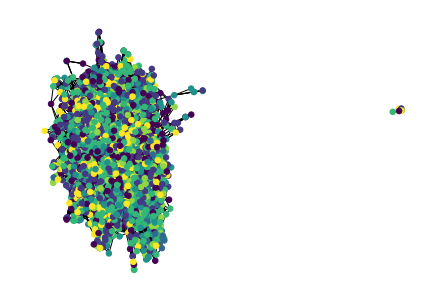

In [ ]:
X = bow
A = kneighbors_graph(X, n_neighbors=4, metric="cosine")

G = nx.Graph(A)
nx.draw(G, node_size=30, pos=nx.spring_layout(G), node_color=df_sample['genre'].cat.codes)

Não é possível definir um padrão visual, o que significa que palavras específicas não estão atribuidas a um gênero musical específico.

## Ponderação de Termos com TFIDF

In [ ]:
# obtendo a VSM com TFIDF
def compute_vsm_tfidf(dataset,lang,domain_stopwords=[], n_features=1000):
  
  d = []
  for index,row in dataset.iterrows():
    if index % 5000 == 0:
      print(index, " rows analysed");
    text = row['lyrics'] #texto do evento
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)
  
  matrix = TfidfVectorizer(max_features=n_features)
  X = matrix.fit_transform(d)
  
  tfidf_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return tfidf_vect_df


vsm = compute_vsm_tfidf(df_sample,'english', n_features=500)
vsm

20000  rows analysed
0  rows analysed


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,afraid,ahead,aliv,alright,answer,anymor,apart,arm,ask,away,babe,babi,ball,band,bear,beat,beauti,begin,believ,belong,best,better,bind,bitch,black,blame,bleed,bless,blind,block,blood,blow,blue,bodi,bone,bout,boy,brain,brand,break,...,turn,understand,voic,wait,wake,walk,walkin,wall,wan,want,warm,wast,watch,water,way,weak,wear,welcom,whisper,white,whoa,wick,wild,wind,window,winter,wish,woah,woman,wonder,word,work,world,worri,write,wrong,yeah,year,yesterday,young
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.618188,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.133163,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.275255,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.184361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.186594,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.19176,0.0,0.0,0.0,0.099546,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.13732,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.140101,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.068875,0.0,0.0,0.000000,0.0,0.000000,0.104389,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291011,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.172036,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.094131,0.081133,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.060478,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.073391,0.0,0.000000,0.0,0.172397,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.540513,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.176137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.047487,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.203416,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.064973,0.000000,0.000000,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0

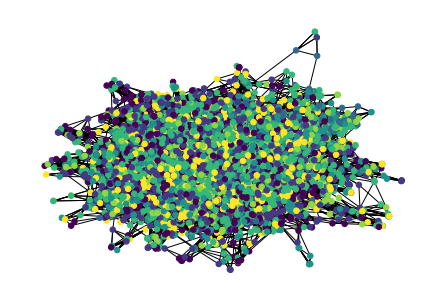

In [ ]:
X = vsm
A = kneighbors_graph(X, n_neighbors=4, metric="cosine")


G = nx.Graph(A)
nx.draw(G, node_size=30, pos=nx.spring_layout(G), node_color=df_sample['genre'].cat.codes)

Tentando novamente com TD-IDF não é possível enxergar um padrão visual.

## Dissimilaridade de cosseno (1-cos) entre dois textos

In [ ]:
# computando dissimilaridade de cosseno

def dis_cosine(matrix, e1, e2):
  dcos = cosine(matrix.iloc[e1,:], matrix.iloc[e2,:])
  return dcos


# exemplo: dissimilaride entre o primeiro (id=0) e o segundo evento (id=1) do vsm-tfidf
dis_cosine(vsm,1,6)

0.9552871436622284

In [ ]:
compare = []
for x in range (0, 5000):
  compare.append(dis_cosine(vsm,0,x))

df_sample["comparison"] = compare

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning:

invalid value encountered in double_scalars



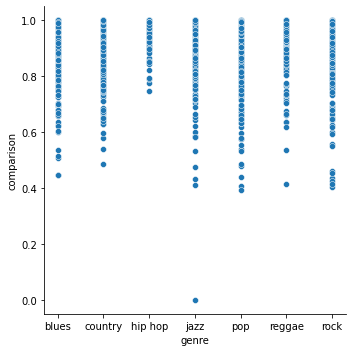

In [ ]:
import seaborn as sns

sns.relplot(x='genre', y='comparison', data=df_sample, kind='scatter')

In [ ]:
compare = []
for x in range (0, 5000):
  compare.append(dis_cosine(vsm,432,x))

df_sample["comparison"] = compare

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning:

invalid value encountered in double_scalars



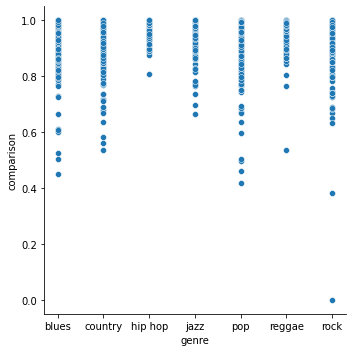

In [ ]:
sns.relplot(x='genre', y='comparison', data=df_sample, kind='scatter')

# Word2Vec + Treinamento

## Sem stemming

In [ ]:
import gensim 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize

stop_words = nltk.corpus.stopwords.words('english')


# percorre cada linha do dataset, preprocessa e armazena na lista documents

documents = []
for index,row in df.iterrows(): # para cada linha do dataset
  if len(row['lyrics']) >= 30: # se a linha possui mais do que 30 caracteres
    tokens = [word.lower() for word in word_tokenize(row['lyrics'])]
    documents.append(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
documents[6]

['piece',
 'mindin',
 'world',
 'knowin',
 'life',
 'come',
 'bring',
 'give',
 'world',
 'know',
 'give',
 'reason',
 'feelin',
 'give',
 'mean',
 'life',
 'go',
 'exist',
 'begin',
 'touch',
 'hair',
 'look',
 'eye',
 'know',
 'know',
 'good',
 'sure',
 'endure',
 'light',
 'world',
 'care',
 'away',
 'ache',
 'give',
 'reason',
 'feelin',
 'give',
 'mean',
 'life',
 'go',
 'exist',
 'begin',
 'bakit',
 'ganyan',
 'bakit',
 'ganyan',
 'ibig',
 'lagi',
 'kang',
 'pagmasdan',
 'umula',
 'umaraw',
 'hindi',
 'pagsasawaan',
 'iyong',
 'katangian',
 'damdamin',
 'ibangiba',
 'kapag',
 'kapiling',
 'sinta',
 'bakit',
 'ganyan',
 'damdamin',
 'maintindihan',
 'kailangan',
 'pagibig',
 'dahil',
 'nagmamahal',
 'magmula',
 'nang',
 'kita',
 'makilala',
 'bakit',
 'ganyan',
 'kung',
 'minsan',
 'nauutal',
 'kaba',
 'kapag',
 'kausap',
 'ngunit',
 'lumalakas',
 'loob',
 'kung',
 'ikaw',
 'nakatawa',
 'bakit',
 'ganyan',
 'damdamin',
 'maintindihan',
 'kailangan',
 'pagibig',
 'dahil',
 'nagmama

In [ ]:
# treinando o Word2Vec a partir dos documents
model = gensim.models.Word2Vec(
        documents, # lista com documents
        size=100, # tamanho da dimensao de cada palavra
        window=10, # tamanho da janela de contexto
        min_count=1, # numero minimo de ocorrencia de uma palavra no texto
        workers=4, # paralelizacao/cpu
        iter=50) # numero maximo de iteracoes

In [ ]:
model['believe']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.5218621 , -2.5009072 , -0.31279898,  2.1737854 , -0.63110924,
       -0.96566063, -2.144046  , -2.8076644 , -0.20387378, -0.4701439 ,
       -1.0971557 , -0.7717535 ,  0.48778573, -0.19539545, -1.4613527 ,
       -0.01319766,  2.6916435 ,  1.5780221 ,  0.4714967 ,  0.5146643 ,
        1.8758749 , -1.0867647 ,  0.0745727 ,  3.1023564 , -0.20241155,
       -4.6346817 , -0.62852913,  2.175849  ,  1.7287894 , -0.6611737 ,
       -1.3175923 , -0.05214965,  1.5120759 , -1.2421837 ,  1.1945161 ,
       -1.6222645 , -0.62211   ,  2.688219  ,  2.4115844 , -2.698624  ,
       -1.2210364 ,  0.37452692,  1.6001434 , -0.9646033 , -0.30336112,
       -0.34210864,  2.4634926 ,  2.1994593 ,  0.28594747, -2.1981673 ,
        0.94698185, -0.33396444, -1.2231815 , -1.0648714 , -1.5796442 ,
       -2.2978652 , -3.2166233 ,  0.8994786 ,  2.6057975 , -2.037592  ,
       -0.64486694,  0.4122475 ,  1.9471493 ,  1.7089466 ,  2.8447053 ,
        2.1095948 ,  1.4256583 , -1.2592047 , -1.1139812 ,  0.01

In [ ]:
# testando o modelo..

palavra = 'life'
model.wv.most_similar(palavra, topn=7) # identificando as 7 palavra mais similares (e.g. cosseno)

[('live', 0.75780189037323),
 ('world', 0.5282854437828064),
 ('existi', 0.525865375995636),
 ('things', 0.49957966804504395),
 ('borame', 0.4938286244869232),
 ('dream', 0.4860384166240692),
 ('strife', 0.48421353101730347)]

In [ ]:
palavra = 'war'
model.wv.most_similar(palavra, topn=7) # identificando as 7 palavra mais similares (e.g. cosseno)

[('americathere', 0.4859340488910675),
 ('nations', 0.48288509249687195),
 ('spiritfarer', 0.4764864444732666),
 ('oppression', 0.4710911512374878),
 ('liberation', 0.4632692039012909),
 ('dungeons', 0.4514448642730713),
 ('nottoodistant', 0.44686731696128845)]

In [ ]:
word2vec = model

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(word2vec, palavras, num_vizinhos=10):
    labels = []
    tokens = []

    for word in palavras:
      palavras_vizinhas = word2vec.most_similar(word,topn=num_vizinhos)
      for item in palavras_vizinhas:
        tokens.append(word2vec[item[0]])
        labels.append(item[0])
      tokens.append(word2vec[word])
      labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=2)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from

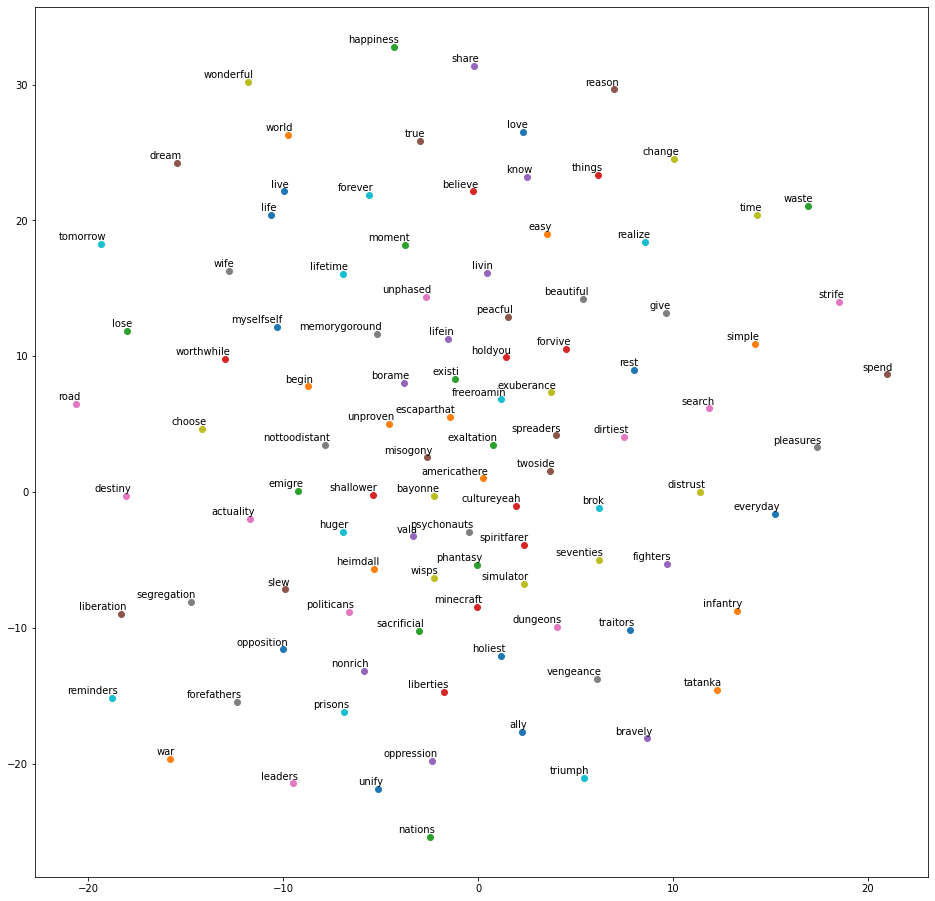

In [ ]:
palavras = ['life','war']

tsne_plot(word2vec,palavras,num_vizinhos=50)

## Com stemming

In [ ]:
documents = []
for index,row in df.iterrows(): # para cada linha do dataset
  if len(row['lyrics']) >= 30: # se a linha possui mais do que 30 caracteres
    text = stemming(row['lyrics'], 'english')
    tokens = [word.lower() for word in word_tokenize(text)]
    documents.append(tokens)

In [ ]:
documents[6]

['piec',
 'mindin',
 'world',
 'knowin',
 'life',
 'come',
 'bring',
 'give',
 'world',
 'know',
 'give',
 'reason',
 'feelin',
 'give',
 'mean',
 'life',
 'go',
 'exist',
 'begin',
 'touch',
 'hair',
 'look',
 'eye',
 'know',
 'know',
 'good',
 'sure',
 'endur',
 'light',
 'world',
 'care',
 'away',
 'ach',
 'give',
 'reason',
 'feelin',
 'give',
 'mean',
 'life',
 'go',
 'exist',
 'begin',
 'bakit',
 'ganyan',
 'bakit',
 'ganyan',
 'ibig',
 'lagi',
 'kang',
 'pagmasdan',
 'umula',
 'umaraw',
 'hindi',
 'pagsasawaan',
 'iyong',
 'katangian',
 'damdamin',
 'ibangiba',
 'kapag',
 'kapil',
 'sinta',
 'bakit',
 'ganyan',
 'damdamin',
 'maintindihan',
 'kailangan',
 'pagibig',
 'dahil',
 'nagmamah',
 'magmula',
 'nang',
 'kita',
 'makilala',
 'bakit',
 'ganyan',
 'kung',
 'minsan',
 'nauutal',
 'kaba',
 'kapag',
 'kausap',
 'ngunit',
 'lumalaka',
 'loob',
 'kung',
 'ikaw',
 'nakatawa',
 'bakit',
 'ganyan',
 'damdamin',
 'maintindihan',
 'kailangan',
 'pagibig',
 'dahil',
 'nagmamah',
 'mag

In [ ]:
# treinando o Word2Vec a partir dos documents
model = gensim.models.Word2Vec(
        documents, # lista com documents
        size=100, # tamanho da dimensao de cada palavra
        window=10, # tamanho da janela de contexto
        min_count=1, # numero minimo de ocorrencia de uma palavra no texto
        workers=4, # paralelizacao/cpu
        iter=50) # numero maximo de iteracoes

In [ ]:
model['believ']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 2.1381714 , -2.8386002 , -0.7636049 ,  2.0270777 ,  0.23901027,
        3.8335838 , -1.2551173 , -0.13594308,  1.405016  ,  1.2826705 ,
       -2.78757   , -0.7859754 , -2.5252101 , -4.5789433 , -1.2821052 ,
       -0.14368533, -1.164216  ,  2.3345244 ,  0.6286273 ,  1.7663492 ,
        0.36583954, -1.8598032 ,  3.1658702 ,  4.925065  ,  2.9163413 ,
       -2.9432864 , -0.5736311 ,  1.3407468 , -0.27905452,  0.6856514 ,
       -0.8528835 , -0.5600575 ,  1.170095  ,  2.2123842 ,  0.14624803,
       -0.7170223 ,  0.24179178,  1.5097464 ,  0.15287617, -1.3950179 ,
        2.2195964 ,  1.1489071 , -0.21555692,  0.50252753,  2.2475758 ,
        1.1789129 ,  0.08737687,  0.21471617,  1.3699626 ,  0.37818986,
        1.1633563 , -1.0941215 ,  1.4447052 , -1.7504232 , -0.99962026,
       -1.82489   , -1.9691827 ,  0.81205344, -1.2900887 , -1.82355   ,
       -3.4573693 ,  0.7221502 ,  0.27817792, -0.67780095, -0.30949903,
        0.47935352,  0.50477177,  0.34643218,  0.11348862, -0.14

In [ ]:
# testando o modelo..

palavra = 'life'
model.wv.most_similar(palavra, topn=7) # identificando as 7 palavra mais similares (e.g. cosseno)

[('live', 0.7488641142845154),
 ('existi', 0.5451589822769165),
 ('world', 0.5069583058357239),
 ('boram', 0.4992315173149109),
 ('strife', 0.4846634864807129),
 ('give', 0.47734901309013367),
 ('myselfself', 0.47357308864593506)]

In [ ]:
palavra = 'war'
model.wv.most_similar(palavra, topn=7) # identificando as 7 palavra mais similares (e.g. cosseno)

[('brok', 0.5719999074935913),
 ('unwag', 0.4572479724884033),
 ('jewimpos', 0.4484219551086426),
 ('oppress', 0.44082021713256836),
 ('vala', 0.43819165229797363),
 ('americather', 0.4345093369483948),
 ('racist', 0.4320024847984314)]

In [ ]:
word2vec = model

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(word2vec, palavras, num_vizinhos=10):
    labels = []
    tokens = []

    for word in palavras:
      palavras_vizinhas = word2vec.most_similar(word,topn=num_vizinhos)
      for item in palavras_vizinhas:
        tokens.append(word2vec[item[0]])
        labels.append(item[0])
      tokens.append(word2vec[word])
      labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=2)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from

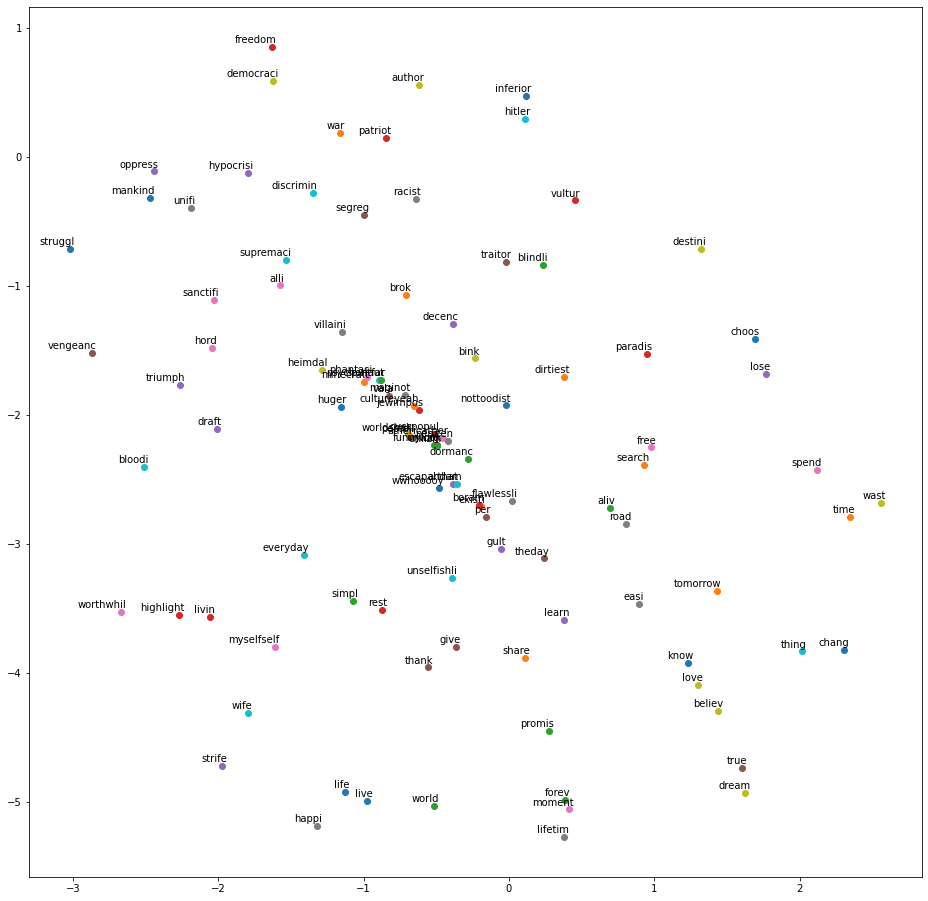

In [ ]:
palavras = ['life','war']

tsne_plot(word2vec,palavras,num_vizinhos=50)

# Visualização Baseada em Tópicos - BERTopic

In [ ]:
!pip install bertopic

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=False)
topics, probs = topic_model.fit_transform(df['lyrics'])

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
topic_model.get_topic_info().head(30)

,Topic,Count,Name
0,-1,19016,-1_days_pain_soul_today
1,0,1366,0_bitch_nigga_niggas_shit
2,1,663,1_girl_sweet_babe_tonight
3,2,650,2_commercial_lyric_breathe_alive
4,3,592,3_waltz_piece_hide_walk
5,4,530,4_lord_holy_thee_heaven
6,5,472,5_music_song_songs_band
7,6,238,6_woman_evil_lady_women
8,7,201,7_blue_moon_moonglow_shoe
9,8,177,8_kiss_darling_lover_whisper


In [ ]:
topic_model.get_topic_info().head(30)

,Topic,Count,Name
0,-1,19016,-1_days_pain_soul_today
1,0,1366,0_bitch_nigga_niggas_shit
2,1,663,1_girl_sweet_babe_tonight
3,2,650,2_commercial_lyric_breathe_alive
4,3,592,3_waltz_piece_hide_walk
5,4,530,4_lord_holy_thee_heaven
6,5,472,5_music_song_songs_band
7,6,238,6_woman_evil_lady_women
8,7,201,7_blue_moon_moonglow_shoe
9,8,177,8_kiss_darling_lover_whisper


In [ ]:
topic_model.get_topics()

{-1: [('days', 0.0025691696290660627),
  ('pain', 0.0024754382594615147),
  ('soul', 0.0024739485463743946),
  ('today', 0.0024690515453463426),
  ('fight', 0.0024516256168419562),
  ('tonight', 0.0023893088952739276),
  ('sleep', 0.0023795081743149503),
  ('stop', 0.002362135362118539),
  ('tear', 0.0023603902602020634),
  ('real', 0.002352980785224403)],
 0: [('bitch', 0.017447130047097293),
  ('nigga', 0.015724715383753602),
  ('niggas', 0.014014452006588494),
  ('shit', 0.012420248616732448),
  ('fuck', 0.010625095650985175),
  ('fuckin', 0.007033566575574861),
  ('damn', 0.004294802042442142),
  ('gettin', 0.004180841736609042),
  ('motherfucker', 0.004156978359955445),
  ('beat', 0.00399491249761886)],
 1: [('girl', 0.010325729085417562),
  ('sweet', 0.007127172524034558),
  ('babe', 0.007000018800677168),
  ('tonight', 0.006097052844947246),
  ('gotta', 0.005361891351886298),
  ('kiss', 0.005240448255263832),
  ('mama', 0.005153514771133077),
  ('girls', 0.00490972517009758),
  

In [ ]:
topic_model.visualize_barchart(top_n_topics=6)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=30)